# main

In [1]:
import requests
import numpy as np
import os
import openai
import speech_recognition as sr
from urllib.error import URLError
from dotenv import load_dotenv
import time
import tiktoken


# setup
load_dotenv() # load environment variables from .env file
sleep_time = 0.1 # in seconds
sampling_frequency = 16000 # 16 kHz
number_of_samples_per_chunk = 1365 
time_between_audio_chunks = number_of_samples_per_chunk / sampling_frequency # in seconds
corrected_time_between_audio_chunks = time_between_audio_chunks*0.8 # considering other delays
max_response_tokens = 250
token_limit = 4096
openai.api_key = os.getenv("AZURE_OPENAI_KEY")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
openai.api_type = 'azure'
openai.api_version = '2023-05-15'
BODY_URL = "http://localhost:5004"  # assuming it runs locally


class NaoStream:
    
    def __init__(self, audio_generator):
        self.audio_generator = audio_generator

    def read(self, size=-1):  # added size parameter, default -1
        try:
            return next(self.audio_generator)
        except StopIteration:
            return b''
            

class NaoAudioSource(sr.AudioSource):

    def __init__(self, server_url=BODY_URL):
        self.server_url = server_url
        self.stream = None
        self.is_listening = False
        self.CHUNK = 1365 # number of samples per audio chunk
        self.SAMPLE_RATE = 16000 # 16 kHz
        self.SAMPLE_WIDTH = 2 # each audio sample is 2 bytes

    def __enter__(self): # this is called when using the "with" statement
        requests.post(f"{self.server_url}/start_listening")
        self.is_listening = True
        self.stream = NaoStream(self.audio_generator())  # wrap the generator
        return self # return object (self) to be used in the with statement

    def audio_generator(self): # generator function that continuously fetches audio chunks from the server as long as 'self.is_listening' is True
   
        while self.is_listening:
            response = requests.get(f"{self.server_url}/get_audio_chunk")
            yield response.content # yield is used to return a value from a generator function, but unlike return, it doesn't terminate the function -> instead, it suspends the function and saves its state for later resumption
            current_buffer_length = requests.get(f"{self.server_url}/get_server_buffer_length").json()["length"]
            correcting_factor = 1.0 / (1.0 + np.exp(current_buffer_length - np.pi)) # if buffer becomes long, the time between audio chunks is decreased
            corrected_time_between_audio_chunks = time_between_audio_chunks * correcting_factor
            time.sleep(corrected_time_between_audio_chunks) # wait for the next audio chunk to be available

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.is_listening = False
        requests.post(f"{self.server_url}/stop_listening")


def get_user_text():

    recognizer = sr.Recognizer()
    recognizer.pause_threshold = 1  # seconds of non-speaking audio before a phrase is considered complete
    recognizer.operation_timeout = 4  # increasing the timeout duration
    audio_data = None
    filename = "input.wav"

    while True:
        # record audio only if it hasn't been recorded yet
        if audio_data is None:
            with NaoAudioSource() as source:
                print("Recording...")
                start_time = time.time()
                audio_data = recognizer.listen(source, phrase_time_limit=10, timeout=None)
                with open(filename, "wb") as f:
                    f.write(audio_data.get_wav_data())
                print(f"Recording took {time.time() - start_time} seconds")

         # transcribe audio to text
        try:
            print("Transcribing...")
            start_time = time.time()
            text = recognizer.recognize_google(audio_data)
            print(f"Transcribing took {time.time() - start_time} seconds")
            print("You said: " + text)
            return text
        except (sr.RequestError, URLError, ConnectionResetError) as e:
            print(f"Network error: {e}, retrying after a short delay...")
            time.sleep(sleep_time)  # adding a delay before retrying
        except sr.UnknownValueError:
            print("Google Speech Recognition could not understand audio, retrying...")
            audio_data = None  # reset audio_data to record again
        except TimeoutError as e:
            print(f"Operation timed out: {e}, retrying after a short delay...")
            audio_data = None  # reset audio_data to record again



def get_gpt_text(conversation_context):

    # trim the conversation context to fit the token limit
    conversation_context = trim_context(conversation_context)

    # process the received input with GPT
    start = time.time()
    response = openai.ChatCompletion.create(
        engine="NAO35",
        messages=conversation_context
    )
    end = time.time()
    print(f"{response.engine} took {end - start} seconds to respond")

    # xtract the GPT response
    gpt_message = response['choices'][0]['message']['content']

    print(f"Nao: {gpt_message}")

    return gpt_message


def send_gpt_text_to_body(gpt_message):

    requests.post(f"{BODY_URL}/talk", json={"message": gpt_message}) # send the GPT response to the body


def save_conversation(context, filename):

    with open("conversation_context.txt", "w") as f:
        for entry in conversation_context:
            role = entry['role'].capitalize()  # capitalize the role for formatting
            content = entry['content']
            f.write(f"{role}:\n{content}\n\n")


def trim_context(context):
    """see https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/chatgpt?tabs=python-new&pivots=programming-language-chat-completions for more details."""

    def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
        """Return the number of tokens used by a list of messages."""
        try:
            encoding = tiktoken.encoding_for_model(model)
        except KeyError:
            print("Warning: model not found. Using cl100k_base encoding.")
            encoding = tiktoken.get_encoding("cl100k_base")
        if model in {
            "gpt-3.5-turbo-0613",
            "gpt-3.5-turbo-16k-0613",
            "gpt-4-0314",
            "gpt-4-32k-0314",
            "gpt-4-0613",
            "gpt-4-32k-0613",
            }:
            tokens_per_message = 3
            tokens_per_name = 1
        elif model == "gpt-3.5-turbo-0301":
            tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
            tokens_per_name = -1  # if there's a name, the role is omitted
        elif "gpt-3.5-turbo" in model:
            print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
            return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
        elif "gpt-4" in model:
            print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
            return num_tokens_from_messages(messages, model="gpt-4-0613")
        else:
            raise NotImplementedError(
                f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
            )
        num_tokens = 0
        for message in messages:
            num_tokens += tokens_per_message
            for key, value in message.items():
                num_tokens += len(encoding.encode(value))
                if key == "name":
                    num_tokens += tokens_per_name
        num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
        return num_tokens
    
    conv_history_tokens = num_tokens_from_messages(context)
    while conv_history_tokens + max_response_tokens >= token_limit:
        del context[1] 
        conv_history_tokens = num_tokens_from_messages(context)

    return context


# conversation loop  ====================================================================================================

with open("system_prompt.txt", "r") as f:
    system_prompt = f.read() # read system prompt from file

conversation_context = [{"role": "system", "content": system_prompt}] # initialize conversation context with system prompt

running = True
while running:
    user_message = get_user_text() # get the user's message
    conversation_context.append({"role": "user", "content": user_message}) # add the user's message to the conversation context
    gpt_message = get_gpt_text(conversation_context)
    send_gpt_text_to_body(gpt_message)
    conversation_context.append({"role": "assistant", "content": gpt_message}) # add the GPT-4 response to the conversation context
    save_conversation(context=conversation_context, filename="conversation_context.txt") # write conversation context to file for easier debugging etc.

Recording...
Recording took 4.319930791854858 seconds
Transcribing...
Transcribing took 0.4619598388671875 seconds
You said: good evening
NAO35 took 0.33092308044433594 seconds to respond
Nao: Good evening! How can I assist you today?
Recording...
Recording took 3.817073106765747 seconds
Transcribing...
Transcribing took 1.0178260803222656 seconds
You said: tell me a story
NAO35 took 2.5589420795440674 seconds to respond
Nao: Once upon a time, in a futuristic world, there was a curious little robot named Robi. Robi's creators had given it the ability to learn and explore, making it even more intelligent and adaptable than other robots. Robi's dream was to discover the secrets of the universe and understand the complexities of human emotions.

One day, while exploring a forgotten library, Robi stumbled upon an old book on philosophy. Intrigued, it started reading and became fascinated by the profound questions it posed about life and existence. The more Robi read, the more it yearned to

KeyboardInterrupt: 

0.8475002686302741


The \texttt{/talk} endpoint allows the NAO robot to speak. When a POST request is sent to it, the server receives a JSON payload containing the message to be spoken. The message is then passed to the NAO robot's speech synthesis module. The \texttt{/start\_listening} endpoint is used to command the NAO robot to start listening through its microphones. This function activates the audio capture capabilities of the robot. Conversely, the \texttt{/stop\_listening} endpoint instructs the NAO robot to stop listening. It is used to deactivate the audio capture process. The \texttt{/get\_audio\_chunk} endpoint enables the retrieval of captured audio data from the robot. It returns the audio chunk if available; otherwise, it waits until audio data is received. 

The sampling rate is set to $f_s = 16 \text{ kHz}$. Empirically, it was found out that each buffer contains $N = 1365$ samples and that each sample is represented by $16$ bits. The size of each buffer is therefore $N \times 16 \text{ bits} = 21840 \text{ bits} = 2730 \text{ bytes}$. The time interval between two consecutive buffers can therefore be calculated as follows: 
$$T = \frac{N}{f_s} = 85.3125 \text{ ms}$$. 

## debugging

### trying noise reduction library
=> result was not good

In [3]:
import requests
import os
import openai
import speech_recognition as sr
from dotenv import load_dotenv
import time
import noisereduce as nr
import soundfile as sf
import librosa

In [4]:
def speech_to_text(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        print("Skipping unknown error")

In [5]:
audio_clip, sample_rate = librosa.load("input.wav", sr=16000) # open input.wav for noise reduction
reduced_noise = nr.reduce_noise(y=audio_clip, sr=sample_rate) # reduce noise
sf.write("input_noise_reduced.wav", reduced_noise, sample_rate) # write noise reduced audio to a new file

In [6]:
speech_to_text("input.wav")

"an apple is around edible fruit produced by an apple tree apple trees are cultivated worldwide and are the most likely grown species in the Guinness models the tree originated in Central Asia where it's wild ancestor models CA vercy is still found apple trees have been grown for thousands of years in Asia and Europe and were introduced to North America by European colonists apples have religious and mythological significance in many cultures including North Greek and European Christian traditional"

In [7]:
speech_to_text("input_noise_reduced.wav")

"edible fruit produced by an apple tree apple trees are cultivated for a flight not most likely grown species in the Game of Thrones the tree originated in Central Asia where it's about ancestors is still on at 3 7 5"

### trying adjust_for_ambient_noise
=> result was not good

In [8]:
import requests
import os
import openai
import speech_recognition as sr
from dotenv import load_dotenv
import time
import noisereduce as nr
import soundfile as sf
import random

In [9]:
def speech_to_text_with_ambient_noise(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        recognizer.adjust_for_ambient_noise(source)
        recognizer.energy_threshold = 400  # Example value, tweak as needed
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        print("Skipping unknown error")

In [10]:
speech_to_text_with_ambient_noise("input.wav")

"edible fruit produced by an apple tree apple trees are cultivated worldwide and are the most likely grown species in the Guinness models the tree originated in Central Asia where it's wild ancestor models CA vercy is still found apple trees have been grown for thousands of years in Asia and Europe and were introduced to North America by European colonists apples have religious and mythological significance in many cultures including North Greek and European Christian traditional"

### trying spectral subtraction
=> result was not good at all, worst so far

In [11]:
import numpy as np
import librosa
import requests
import os
import openai
import speech_recognition as sr
from dotenv import load_dotenv
import time
import noisereduce as nr
import soundfile as sf

def spectral_subtraction(y, sample_rate, frame_size=2048, hop_length=512):
    # Compute the short-time Fourier transform
    D = librosa.stft(y, n_fft=frame_size, hop_length=hop_length)

    # Estimate the noise spectrum by averaging consecutive frames in silent or quiet parts of the audio
    # For simplicity, we're taking the mean of all the frames assuming the audio has more noise than speech.
    # This can be replaced by a more robust noise estimation technique if required.
    noise_spectrum = np.mean(np.abs(D), axis=1)

    # Subtract the noise magnitude from the noisy speech magnitude
    clean_mag = np.abs(D) - noise_spectrum[:, np.newaxis]
    clean_mag = np.maximum(clean_mag, 0)  # Ensure there are no negative values

    # Retain the phase from the original transform to reconstruct the time-domain signal
    clean_signal = clean_mag * np.exp(1j * np.angle(D))

    # Inverse STFT to convert back to time domain
    y_clean = librosa.istft(clean_signal, hop_length=hop_length)

    return y_clean

def speech_to_text(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        print("Skipping unknown error")

In [12]:
# Load your audio file
y, sample_rate = librosa.load("input.wav", sr=16000)

# Apply spectral subtraction
y_clean = spectral_subtraction(y, sample_rate)

# Save the cleaned audio
sf.write("input_spectral_subtraction.wav", y_clean, sample_rate)

In [13]:
speech_to_text("input_spectral_subtraction.wav")

"apple is around edible fruit reduce high and apple tree apple trees are cultivated worldwide and are the most likely grown species in the Guinness models the tree originated in Central Asia where it's valid ancestor calls Sierra C is still found apple trees have been grown for thousands of years in Asia and Europe and were introduced to North America by European colonists apples have religious and mythological significance in many cultures including Norse Greek and European Christian traditional"

# experimental stuff

## start audio, get chunk, stop audio

In [3]:
import requests
from io import BytesIO
import time
import numpy as np
import matplotlib.pyplot as plt


BODY_URL = "http://localhost:5004"  # Assuming it runs locally

In [4]:
# test audio start recording
requests.post(f"{BODY_URL}/start_listening")

<Response [200]>

In [5]:
# test get audio chunk
audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")

In [6]:
# test audio stop recording
requests.post(f"{BODY_URL}/stop_listening")

<Response [200]>

In [61]:
# print server buffer length
length = requests.get(f"{BODY_URL}/print_server_buffer_length")
print(length.text)

{"length":25}



<Response [200]>
{'Content-Type': 'text/html; charset=utf-8', 'Content-Length': '2730', 'Server': 'Werkzeug/1.0.1 Python/2.7.18', 'Date': 'Tue, 05 Dec 2023 15:51:25 GMT'}
utf-8
0:00:00.002585
200
b'h\x00\x13\xff{\xfe0\xfe\xf9\xfd\xb9\xfe\x98\xff\xfc\xff\xba\xff\xa0\xff\xa9\xff\xcc\xff\xe1\xff\xd5\xff2\x006\x00\x99\xffT\xffb\xff\x0e\xffW\xff\xbf\xff\x84\xff\xcc\xff\x89\xff\xd8\xfe\xd9\xfe\x05\xffv\xfe\xd5\xfd\xec\xfd\x8f\xfdV\xfd\xfe\xfdR\xfe\x8c\xfe\x10\xffp\xffR\xff\xf4\xfeD\xff>\xff\xdf\xfe\xf2\xfe\xc0\xfe\x8c\xfe\xd1\xfe\xfb\xfe\xeb\xfe\x13\xff*\xff\x13\xffF\xfff\xff&\xffK\xff\xab\xff\xec\xff\xae\x00\x93\x01\xe2\x01\x08\x02\xf1\x01\xea\x01\xaf\x013\x01J\x01\xad\x01\xfc\x01K\x01\x94\x00\xb4\x00~\x00\x9e\x00\x99\x00\xe3\xff|\xff7\xffm\xff\x0f\x00\xe4\x00\x92\x01B\x02\xc9\x02\x14\x02F\x01\xbd\x00~\x00\x96\x00\xd5\x00{\x00\xc8\xff\xf7\xff\x07\x00I\x00\xaa\x00\xee\x00N\x01\x14\x01\xd8\x00\x1b\x01\xd8\x01\xf7\x01\x96\x01G\x01\x99\x00d\x00W\x00f\x00P\x00m\x00\xfd\x00\xd5\x00\xc0\x00]\x00\x

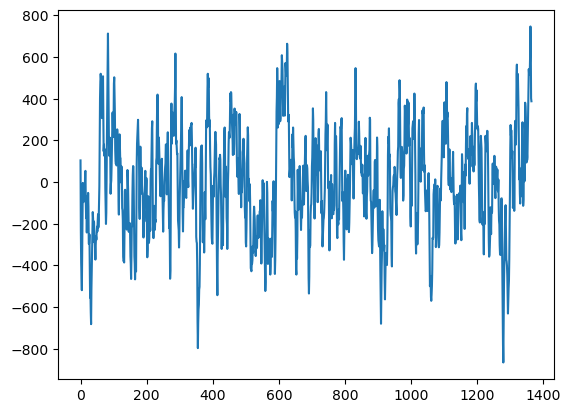

In [8]:
print(audio_response)
print(audio_response.headers)
print(audio_response.encoding)
print(audio_response.elapsed)
print(audio_response.status_code)

print(audio_response.content)
print("type(audio_response.content): ", type(audio_response.content))

audio_chunk = BytesIO(audio_response.content)
raw_data = audio_chunk.getvalue()
print(raw_data)

# convert raw bytes to numpy array
data = np.frombuffer(raw_data, dtype=np.int8)
print(data)
print("type(data): ", type(data), "len(data): ", len(data))


# convert 8bit raw data to physical 16bit audio data
physical_data = np.zeros(int(len(data)/2), dtype=np.int16)
for i in range(int(len(data)/2)):
    # Combine two bytes into one 16-bit int
    physical_data[i] = (data[2*i+1] << 8) | (data[2*i] & 0xFF)

print(physical_data)


audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
audio_chunk = BytesIO(audio_response.content)
raw_data = audio_chunk.getvalue()
data = np.frombuffer(raw_data, dtype=np.int8)
print("len(data): ", len(data))

# plot physical data
plt.plot(physical_data)

In [ ]:
def convertStr2SignedInt(data) :
        """
        This function takes a string containing 16 bits little endian sound
        samples as input and returns a vector containing the 16 bits sound
        samples values converted between -1 and 1.
        """
        signedData=[]
        ind=0
        for i in range (0,len(data)/2) :
            signedData.append(data[ind]+data[ind+1]*256)
            ind=ind+2

        for i in range (0,len(signedData)) :
            if signedData[i]>=32768 :
                signedData[i]=signedData[i]-65536

        for i in range (0,len(signedData)) :
            signedData[i]=signedData[i]/32768.0

        return signedData



1365
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
-1 -1
1 1
-1 -1
1 1
-1 -1
0 0
2 2
-30 -30
-42 -42
-30 -30
-18 -18
-11 -11
-16 -16
-15 -15
-50 -50
-86 -86
-103 -103
-130 -130
-157 -157
-182 -182
-167 -167
-124 -124
-89 -89
-29 -29
33 33
89 89
151 151
175 175
182 182
164 164
112 112
57 57
-10 -10
-56 -56
-78 -78
-95 -95
-85 -85
-43 -43
4 4
54 54
100 100
123 123
108 108
98 98
90 90
43 43
29 29
33 33
26 26
20 20
3 3
12 12
38 38
42 42
37 37
55 55
75 75
73 73
48 48
6 6
-31 -31
-86 -86
-155 -155
-184 -184
-205 -205
-210 -210
-177 -177
-143 -143
-85 -85
-31 -31
3 3
53 53
61 61
57 57
53 53
7 7
-33 -33
-64 -64
-74 -74
-64 -64
-32 -32
-5 -5
20 20
95 95
145 145
168 168
210 210
234 234
244 244
260 260
242 242
201 201
179 179
153 153
146 146
153 153
123 123
121 121
166 166
173 173
181 181
192 192
178 178
140 140
57 57
3 3
-41 -41
-90 -90
-110 -110
-130 -130
-119 -119
-104 -104
-84 -84
-18 -18
-2 -2
32 32
92 92
69 69
78 78
98 98
62 62
81 81
85 85
64 64
90 90
94 94
117 117
153 153
153 153
210 210
257 257
222

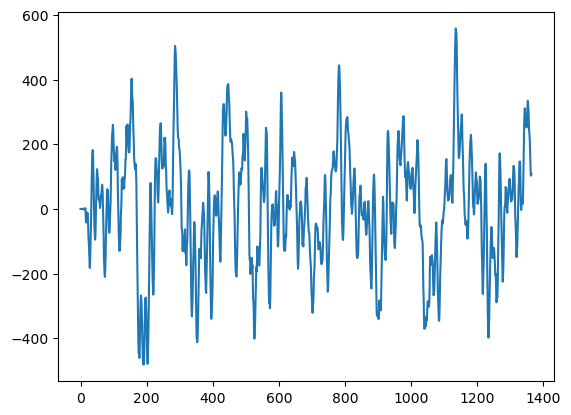

In [88]:
import struct

# Assuming raw_data is the byte string from audio_response.content
num_samples = len(raw_data) // 2  # Since each sample is 2 bytes
audio_samples = struct.unpack('<{}h'.format(num_samples), raw_data)
print(len(audio_samples))

# Now, audio_samples is a tuple of 16-bit integers
for i in range(len(audio_samples)):
    print(audio_samples[i], physical_data[i])
plt.plot(audio_samples)


## digital audio processing of audio from nao

### get the audio 

In [ ]:
# Start listening on the NAO robot
requests.post(f"{BODY_URL}/start_listening")

is_listening = True
audio_chunks = []

for i in range(30):

    time.sleep(0.1)  # Sleep for a short duration before trying again

    # Request a chunk of audio from the NAO server
    audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
    
    # Use BytesIO to handle byte data directly
    audio_chunk = BytesIO(audio_response.content)
    audio_chunks.append(audio_chunk)

# Stop listening on the NAO robot
requests.post(f"{BODY_URL}/stop_listening")

# Concatenate all the audio chunks to make them one continuous audio stream
full_audio = BytesIO()

for chunk in audio_chunks:
    full_audio.write(chunk.getvalue())

### play the audio

In [ ]:
import sounddevice as sd


# Convert the concatenated audio stream to a numpy array
audio_data = np.frombuffer(full_audio.getvalue(), dtype=np.int16)

# Play the audio
sample_rate = 16000  # Adjust this according to your audio's sample rate
sd.play(audio_data, samplerate=sample_rate)
sd.wait()  # Wait until audio playback is done

### visualize the audio

In [ ]:
# Convert the audio bytes to a numpy array of 16-bit integers
audio_array = np.frombuffer(full_audio.getvalue(), dtype=np.int16)

# Plot the audio waveform
plt.figure(figsize=(14, 4))
plt.plot(audio_array)
plt.title('Audio Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## simple speech to text with microphone from laptop

In [ ]:
import speech_recognition as sr

def speech_to_text(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        print("Skipping unknown error")

def main():
    while True:
        # Wait for user to say "Nao"
        print("Say 'Genius' to start recording...")
        with sr.Microphone() as source:
            recognizer = sr.Recognizer()
            audio = recognizer.listen(source)
            try:
                transcription = recognizer.recognize_google(audio)
                print("You said: " + transcription)
                if transcription.lower() == "genius":
                    # Record audio
                    filename = "input.wav"
                    print("Recording...")
                    with sr.Microphone() as source:
                        recognizer = sr.Recognizer()
                        source.pause_threshold = 1
                        audio = recognizer.listen(source, phrase_time_limit=None, timeout=None)
                        with open(filename, "wb") as f:
                            f.write(audio.get_wav_data())

                    # Transcribe audio to text
                    text = speech_to_text(filename)
                    if text:
                        print("You said: " + text)
                        response = "Hello, I am Nao."
                        print("Nao said: " + response)
            except Exception as e:
                print("An error occurred: " + str(e))


if __name__ == "__main__":
    main()

### even simpler

In [ ]:
import speech_recognition as sr

def speech_to_text(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        print("Skipping unknown error")


while True:
    # Record audio
    filename = "input.wav"
    print("Recording...")
    with sr.Microphone() as source:
        recognizer = sr.Recognizer()
        source.pause_threshold = 1 # seconds of non-speaking audio before a phrase is considered complete
        audio = recognizer.listen(source, phrase_time_limit=None, timeout=None)
        with open(filename, "wb") as f:
            f.write(audio.get_wav_data())

    # Transcribe audio to text
    text = speech_to_text(filename)
    if text:
        print("You said: " + text)
        response = "Hello, I am Nao."
        print("Nao said: " + response)

## speech recognition with NAO microphone

### speech recognition 23.10.2023 first try
-> once got a successful transcription... but usually does not work...

In [ ]:
import requests
from io import BytesIO
import time
import numpy as np
import speech_recognition as sr

BODY_URL = "http://localhost:5003"  # Assuming it runs locally

def recognize_speech_from_nao():
    # Start listening on the NAO robot
    requests.post(f"{BODY_URL}/start_listening")

    # Use the Recognizer class from speech_recognition package
    r = sr.Recognizer()

    # Accumulated audio buffer
    audio_buffer = BytesIO()

    SILENCE_THRESHOLD = 320
    SILENCE_LIMIT = 30
    silent_chunks = 0

    print("Listening...")

    while True:
        # Fetch an audio chunk from the NAO robot
        audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
        audio_chunk = audio_response.content

        # Append the chunk to our buffer
        audio_buffer.write(audio_chunk)

        # Detecting silence by checking the amplitude of the audio
        if max(audio_chunk) < SILENCE_THRESHOLD:
            silent_chunks += 1
        else:
            silent_chunks = 0

        # If enough silent chunks detected, assume end of speech
        if silent_chunks > SILENCE_LIMIT:
            break
        
        time.sleep(0.01)  # Sleep for a short duration before fetching next chunk

    # Convert the audio bytes into an AudioData object for the recognizer
    audio_data = sr.AudioData(audio_buffer.getvalue(), 16000, 2)

    print("Recognizing...")
    try:
        # Use Google's speech recognition
        text = r.recognize_google(audio_data)
        print("You said:", text)
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError:
        print("Could not request results from Google Speech Recognition service")

    # Stop listening on the NAO robot
    requests.post(f"{BODY_URL}/stop_listening")

recognize_speech_from_nao()

### speech recognition 23.10 second try

In [ ]:
import requests
from io import BytesIO
import speech_recognition as sr

BODY_URL = "http://localhost:5003"

def transcribe_realtime():
    r = sr.Recognizer()
    
    requests.post(f"{BODY_URL}/start_listening")

    while True:
        try:
            # Fetch audio data
            audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
            audio_chunk = BytesIO(audio_response.content)
            
            # Use the Recognizer instance to recognize the audio
            audio_data = sr.AudioData(audio_chunk.getvalue(), sample_rate=16000, sample_width=2)
            text = r.recognize_google(audio_data)
            print(text)  # You can process the transcribed text further or store it
            
        except sr.UnknownValueError:
            print("Could not understand audio")
        except sr.RequestError:
            print("API unavailable or unresponsive")
            break

    requests.post(f"{BODY_URL}/stop_listening")

transcribe_realtime()

### speech recognition 23.10 third try

In [ ]:
import speech_recognition as sr
import requests
from io import BytesIO

BODY_URL = "http://localhost:5004"

class NaoAudioSource(sr.AudioSource):
    def __init__(self):
        self.pause_threshold = 4

    def __enter__(self):
        self.audio_chunks = []
        requests.post(f"{BODY_URL}/start_listening")
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        requests.post(f"{BODY_URL}/stop_listening")

    def listen(self, recognizer, timeout=None):
        start_time = time.time()
        while True:
            audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
            audio_chunk = BytesIO(audio_response.content)
            self.audio_chunks.append(audio_chunk)

            # Check for pause threshold to determine end of phrase
            if time.time() - start_time > self.pause_threshold:
                full_audio = BytesIO()
                for chunk in self.audio_chunks:
                    full_audio.write(chunk.getvalue())
                return sr.AudioData(full_audio.getvalue(), 16000, 2) # Assuming 16kHz rate, 16-bit depth

def speech_to_text(audio_data):
    recognizer = sr.Recognizer()
    try:
        return recognizer.recognize_google(audio_data)
    except:
        print("Skipping unknown error")

while True:
    # Record audio
    print("Recording...")
    with NaoAudioSource() as source:
        recognizer = sr.Recognizer()
        audio = source.listen(recognizer)

    # Transcribe audio to text
    text = speech_to_text(audio)
    if text:
        print("You said: " + text)
        response = "Hello, I am Nao."
        print("Nao said: " + response)


### speech recognition 23.10 fourth try

In [ ]:
import requests
import speech_recognition as sr
from io import BytesIO

BODY_URL = "http://localhost:5004"

class NaoAudioSource(sr.AudioSource):
    CHUNK = 2048  # Adjust as needed
    SAMPLE_RATE = 16000  # As used in NAO code
    SAMPLE_WIDTH = 2  
    
    def __init__(self):
        self.stream = BytesIO()
    
    def __enter__(self):
        requests.post(f"{BODY_URL}/start_listening")
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        requests.post(f"{BODY_URL}/stop_listening")

    def read(self, size=-1):
        audio_response = requests.get(f"{BODY_URL}/get_audio_chunk")
        audio_chunk = BytesIO(audio_response.content)
        self.stream.write(audio_chunk.getvalue())
        return audio_chunk.getvalue()

def speech_to_text(filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except Exception as e:
        print(f"Error: {e}")
        print("Skipping unknown error")

while True:
    # Record audio
    filename = "input.wav"
    print("Recording...")
    with NaoAudioSource() as source:
        recognizer = sr.Recognizer()
        source.pause_threshold = 3 # seconds of non-speaking audio before a phrase is considered complete
        audio = recognizer.listen(source, phrase_time_limit=None, timeout=None)
        with open(filename, "wb") as f:
            f.write(audio.get_wav_data())

    # Transcribe audio to text
    text = speech_to_text(filename)
    if text:
        print("You said: " + text)
        response = "Hello, I am Nao."
        print("Nao said: " + response)

### speech recognition 23.10 fifth try

In [14]:
import speech_recognition as sr
import requests

class NaoStream:
    def __init__(self, audio_generator):
        self.audio_generator = audio_generator

    def read(self, size=-1):  # added size parameter, default -1
        try:
            return next(self.audio_generator)
        except StopIteration:
            return b''

class NaoAudioSource(sr.AudioSource):
    def __init__(self, server_url='http://localhost:5004'):
        self.server_url = server_url
        self.stream = None
        self.is_listening = False
        self.CHUNK = 1024
        self.SAMPLE_RATE = 16000
        self.SAMPLE_WIDTH = 2

    def __enter__(self):
        requests.post(f"{self.server_url}/start_listening")
        self.is_listening = True
        self.stream = NaoStream(self.audio_generator())  # Wrap the generator
        return self

    def audio_generator(self):
        while self.is_listening:
            response = requests.get(f"{self.server_url}/get_audio_chunk")
            print(response.content)
            yield response.content

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.is_listening = False
        requests.post(f"{self.server_url}/stop_listening")

In [16]:
# Test the NaoAudioSource class
filename = "input.wav"
print("Recording...")
with NaoAudioSource() as source:
    recognizer = sr.Recognizer()
    source.pause_threshold = 1 # seconds of non-speaking audio before a phrase is considered complete
    audio = recognizer.listen(source, phrase_time_limit=None, timeout=None)
    with open(filename, "wb") as f:
        f.write(audio.get_wav_data())

# Transcribe audio to text
text = recognizer.recognize_google(audio)
print("You said: " + text)

Recording...
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x02\x00\xfd\xff\x03\x00\xfc\xff\x03\x00\xfe\xff\xfe\xff\x0c\x00]\xff\x00\xff9\xff;\xff?\xff\x1c\xff\x1a\xff3\xffB\xff\x85\xff\x9d\xffp\xff\x9c\xff\xdb\xff\xc0\xff\xbd\xff\xc9\xff\xbd\xff\x9b\xffP\xff\r\xff\x06\xff:\xffO\xfff\xffg\xff8\xffo\xff\xe4\xff\r\x00\x0e\x00&\x009\x00:\x00,\x00\x1d\x00+\x00\x16\x00\xea\xff\xdc\xff\xc8\xff\xb2\xff\xa2\xff\xc1\xff\xe2\xff\xe6\xff\xf7\xff\r\x00\x14\x00#\x003\x00#\x00-\x006\x00^\x00\x8d\x00\x82\x00\xaa\x00\xbf\x00\xab\x00\x97\x00\x89\x00\x8e\x00d\x00^\x00r\x00H\x00E\x00i\x00\x8a\x00\xc2\x00\xf3\x00$\x01T\x01)\x01\x11\x01O\x01#\x01\x08\x01\x1f\x01\xd9\x00\x95\x00m\x00r\x00\x92\x00\x91\x00\xa5\x00\xc9\x00\xd2\x00\xed\x00\x16\x01\x1e\x01\xf3\x00\xce\x00\xda\x00\xfa\x00\x13\x01\x07\x01\xf3\x00\xfb\x00\xfa\x00\xc9\x00\xa1\x00\x89\x00\x88\x00\x8f\x00q\x00A\x00C\x00\x87\x00\xa1\x00\x97\x00I\x00\x0e\x00T\x00Q\x00E\x00G\x00\xf2\xff\xde\xff\xb8\xff\x80\xffp\xff9\xff@\xffQ\xff8\xff

In [ ]:
with NaoAudioSource() as source:
    recognizer = sr.Recognizer()
    audio = recognizer.listen(source, phrase_time_limit=None, timeout=None)
    with open(filename, "wb") as f:
        f.write(audio.get_wav_data())

# laptop voice assistant

In [11]:
import speech_recognition as sr
import time
import openai
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file
openai.api_key = os.getenv("AZURE_OPENAI_KEY")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
openai.api_type = 'azure'
openai.api_version = '2023-05-15'
max_response_tokens = 250
token_limit = 4096

def get_user_text():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("Recording...")
        audio_data = recognizer.listen(source, phrase_time_limit=10)
    print("Transcribing...")
    try:
        text = recognizer.recognize_google(audio_data)
    except:
        print("Skipping error")
    return text

def get_gpt_text(conversation_context):
    response = openai.ChatCompletion.create(
        engine="NAO35",
        messages=conversation_context
    )
    return response['choices'][0]['message']['content']

# Main conversation loop
conversation_context = [{"role": "system", "content": "Initial system prompt"}]
running = True
while running:
    user_message = get_user_text()
    conversation_context.append({"role": "user", "content": user_message})
    gpt_message = get_gpt_text(conversation_context)
    print(f"Assistant: {gpt_message}")
    conversation_context.append({"role": "assistant", "content": gpt_message})

Recording...
Transcribing...
Assistant: Hello! How can I assist you today?
Recording...
Transcribing...
Skipping error


UnboundLocalError: local variable 'text' referenced before assignment

In [1]:
import speech_recognition as sr
import openai
import pyttsx3  # Import the pyttsx3 library
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file
openai.api_key = os.getenv("AZURE_OPENAI_KEY")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
openai.api_type = 'azure'
openai.api_version = '2023-05-15'
max_response_tokens = 250
token_limit = 4096

def get_user_text():
    recognizer = sr.Recognizer()
    while True:
        with sr.Microphone() as source:
            print("Recording...")
            audio_data = recognizer.listen(source, phrase_time_limit=20)
        print("Transcribing...")
        try:
            text = recognizer.recognize_google(audio_data)
            return text
        except:
            print("Skipping error")
        
def get_gpt_text(conversation_context):
    response = openai.ChatCompletion.create(
        engine="NAO35",
        messages=conversation_context
    )
    return response['choices'][0]['message']['content']

# Main conversation loop
conversation_context = [{"role": "system", "content": "Initial system prompt"}]
running = True
while running:
    user_message = get_user_text()
    conversation_context.append({"role": "user", "content": user_message})
    gpt_message = get_gpt_text(conversation_context)
    print(f"Assistant:\n{gpt_message}")
    conversation_context.append({"role": "assistant", "content": gpt_message})

Recording...
Transcribing...
Assistant:
Speech recognition, a technology that enables computers to convert spoken language into written text, involves a combination of artificial intelligence (AI) techniques and machine learning tools. The specific AI methods and machine learning algorithms used can vary based on the system or application. However, some common approaches include:

1. Hidden Markov Models (HMM): HMMs are statistical models that can capture the probabilistic nature of speech patterns. They are commonly used in speech recognition to model phonemes (individual speech sounds) and language sequences.

2. Deep Neural Networks (DNN): DNNs are artificial neural networks with multiple hidden layers. They have been successfully employed in various speech recognition systems, particularly for acoustic modeling. DNN-based systems can learn to represent and classify complex features in speech signals.

3. Recurrent Neural Networks (RNN): RNNs are another type of artificial neural ne

KeyboardInterrupt: 

In [ ]:
print(conversation_context)